# Mel Spectrograms
The purpose of this notebook is to explore the audio data files using Mel Spectrograms. In my previous effort I have used discrete FFT analysis as training data.

This work was inspired by Sercan Ö. Arık and Markus Kliegl et al (2017), "Convolutional Recurrent Neural Networks for Small-Footprint Keyword Spotting", *Baidu Silicon Valley Artificial IntelligenceLab,1195 Bordeaux Dr. Sunnyvale, CA 94089*

The training and test data is prepared using the method described in the above paper. 40 channel Mel Spectrograms of the 16kHz mono audio files are produced using a 10ms sliding window of size four(4) seconds. In addition, the mel spectrogram is constrained to the frequency range of interest which is above 200 Hz and below 8kHz.

The data for each Mel Spectrogram is saved, un-rolled, as a csv row in an ouput file. The file name prefix is the source audio file name. The resulting files are very large, in the order of 10s of GBytes.

In [1]:
%matplotlib inline
import seaborn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import csv

In [2]:
source_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/16k/'
destination_directory = r'/Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/'

In [3]:
# Find the audio wav files in the source folder
raw_files = []
for file in os.listdir(source_directory):
    if file.endswith(".wav"):
        raw_files.append(file)
        print(raw_files[-1])
        

161225-000.wav
161225-001.wav
161225-002.wav
161225-003.wav
161225-004.wav
161225-005.wav
161225-006.wav


In [4]:
# prepare the destination directory if not already available
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

### Calculate the mel spectrograms for the data

In [5]:
def calc_mel(x, sr, hop_length):
    S = librosa.feature.melspectrogram(x, sr=sr, n_mels=40, fmin=200, fmax=8000, hop_length=hop_length)
    # Convert to log scale (dB) using peak power as reference.
    log_S = librosa.logamplitude(S, ref_power=np.max)
    return log_S

def load_file(filename, sample_rate = 16000):
    data, sample_rate = librosa.load(filename, sr=sample_rate)
    return (data, sample_rate)

(40, 12325)


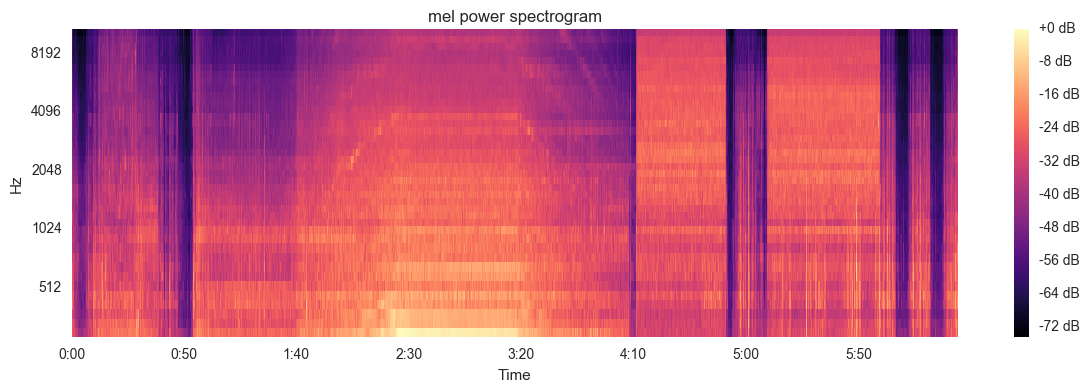

(40, 19042)


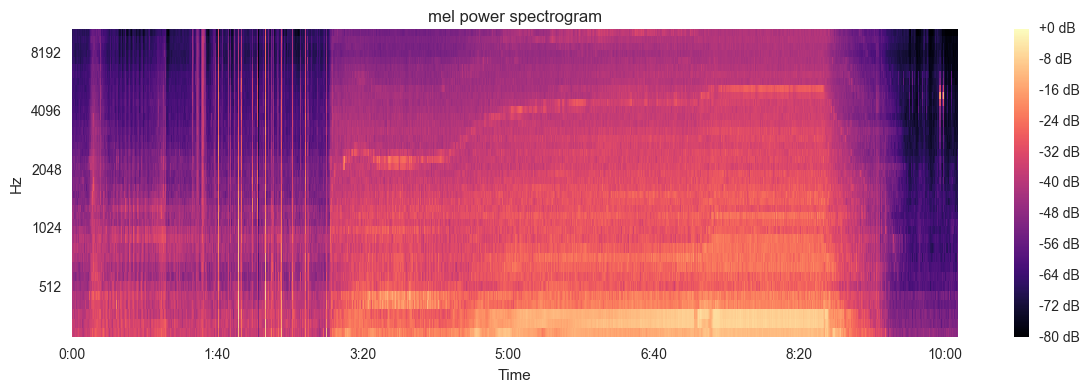

(40, 1607)


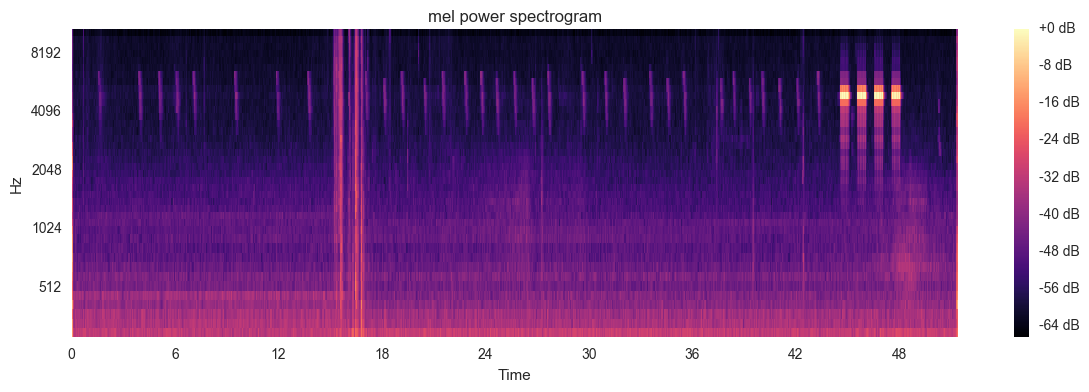

(40, 1830)


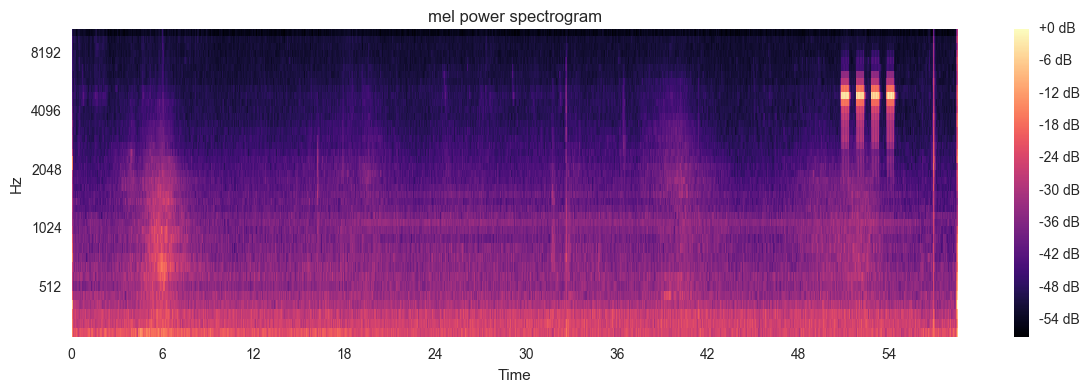

(40, 1819)


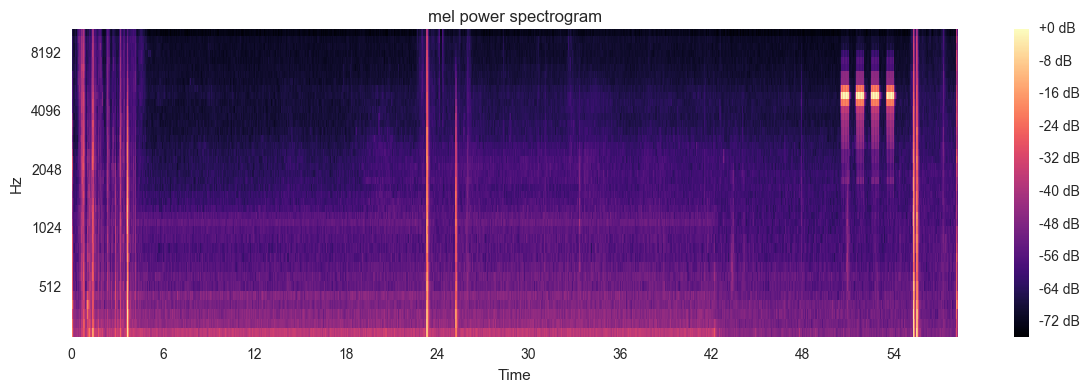

(40, 1589)


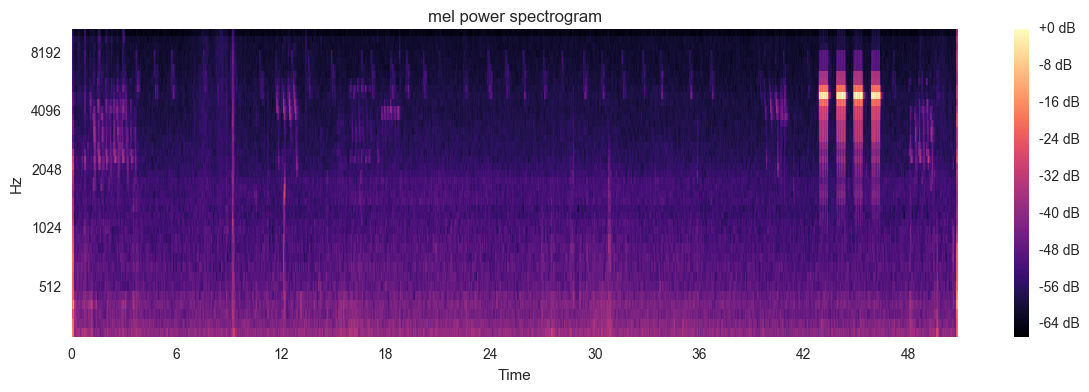

(40, 4933)


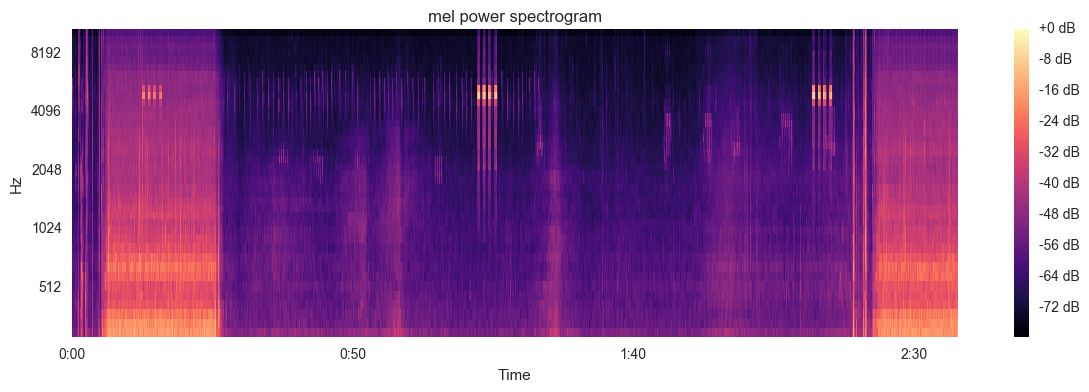

In [22]:
%%time
# Let's make and display a mel-scaled power (energy-squared) spectrogram
for filename in raw_files:
    data, sample_rate = load_file(os.path.join(source_directory, filename))
    log_S = calc_mel(data, sample_rate,None)
    print(log_S.shape)
    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, x_axis='time', sr=sample_rate, y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    plt.show()

### Look at an example four second sample 
The `hop_length` is selected for a 10ms stride (see *Convolutional Recurrent Neural Networks for Small-Footprint Keywork Spotting*)

This sample is chosen to include the start of the target beep sequence.

(40, 401)


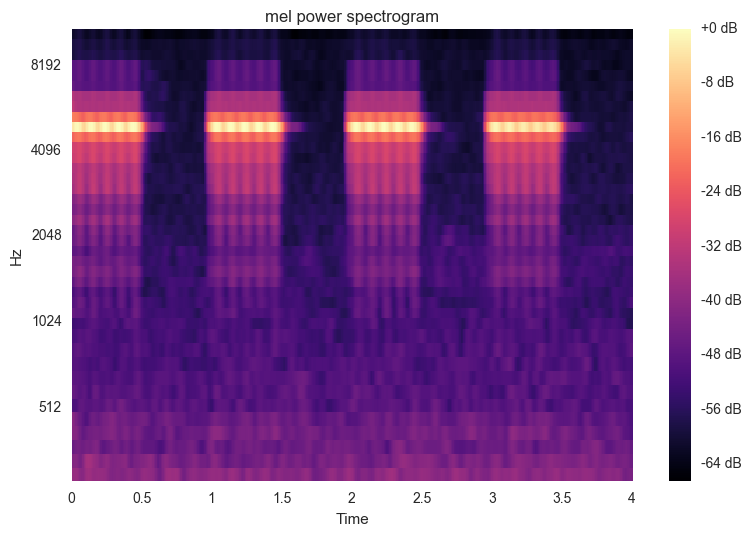

In [6]:
filename = raw_files[-2]
start_sample = 686343 # start of beep signal for this file
stride = 0.01
sample_length = 4 #seconds
data, sample_rate = load_file(os.path.join(source_directory, filename))
hop_length = int(sample_rate*stride)
log_S = calc_mel(data[start_sample:start_sample+sample_rate*sample_length], sample_rate, hop_length=hop_length)

print(log_S.shape)

librosa.display.specshow(log_S, x_axis='time', sr=sample_rate, y_axis='mel', hop_length=hop_length)

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()
plt.show()

# Write the mel data for sample segments
The following functions perform the analysis on the complete audio data set and save the result to disk. As mentioned above the analysis calculation uses a sliding four(4) second window with a 10ms stride.

**Note: This will take a long time to complete and will require a computer with at least 16GB RAM preferably more.**

In [6]:
stride = 0.01
sample_length = 4 #seconds

def plot_mel(data, hop_length):
    librosa.display.specshow(data, x_axis='time', sr=sample_rate, y_axis='mel', hop_length=hop_length)

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()
    plt.show()
    
def save_mel_data(prefix, data):
    '''
    Save mel data to disk. Input data is an array of mel 2d matrices.
    We need to iterate the array and unroll each matrix to occupy a single row in the output file.
    Each matrix has dimensions 40 x 401 (there are 40 mel channels for a 4 sec sample).
    '''
    data = np.asarray(data)
    print('Saving mel data: %s'%prefix)
    print(data.shape)
    
    output_file = '{0}{1}-mel.csv'.format(destination_directory,prefix)
    rows = []
    for mel in data:
        row = mel.flatten() # default row-major
        rows.append(row)

    np.savetxt(output_file, rows, delimiter=',')

    print('Done: %s'%output_file)
    

In [7]:
%%time

for filename in raw_files[1:]:
    print(filename)
    mel = []
    data, sample_rate = load_file(os.path.join(source_directory, filename))
    hop_length = int(sample_rate*stride)
    # perform mel calculation for each sliding window
    for i in np.arange(0,len(data)-(sample_length*sample_rate),(int(stride*sample_rate))):
        offset = i
        x = data[offset:offset+(sample_length*sample_rate)]
        log_S = calc_mel(x, sample_rate, hop_length=hop_length)
        mel.append(log_S)

    save_mel_data(filename, mel)

161225-001.wav
Saving mel data: 161225-001.wav
(60532, 40, 401)
Done: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-001.wav-mel.csv
161225-002.wav
Saving mel data: 161225-002.wav
(4742, 40, 401)
Done: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-002.wav-mel.csv
161225-003.wav
Saving mel data: 161225-003.wav
(5456, 40, 401)
Done: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-003.wav-mel.csv
161225-004.wav
Saving mel data: 161225-004.wav
(5419, 40, 401)
Done: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-004.wav-mel.csv
161225-005.wav
Saving mel data: 161225-005.wav
(4684, 40, 401)
Done: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-005.wav-mel.csv
161225-006.wav
Saving mel data: 161225-006.wav
(15383, 40, 401)
Done: /Volumes/ThorsHammer/Data Science/data/audio-recognition/mel/161225-006.wav-mel.csv
CPU times: user 2h 31min 59s, sys: 29min 47s, total: 3h 1min 47s
Wall time: 1h 4

### Test the Output
Read back a sample and plot the mel spectrogram to verify the data transformation.

In [71]:
# Test file
import csv
raw_csv = []
with open (os.path.join(destination_directory,'161225-002.wav-mel.csv'), 'rb') as f:
    reader = csv.reader(f, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        raw_csv.append(row)

In [72]:
mel_data = []
for row in raw_csv:
    mel = np.asarray(row).reshape((40,401))
    mel_data.append(mel)
mel_data = np.asarray(mel_data).astype('float32')

In [73]:
np.asarray(mel_data).shape

(225, 40, 401)

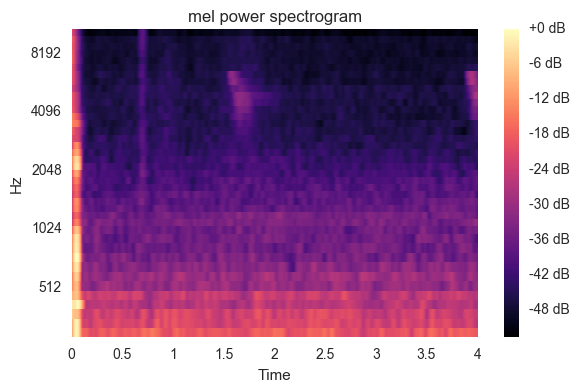

In [74]:
plot_mel(mel_data[0],160)


The above plot looks good.